In [3]:

import os
import numpy as np # linear algebra
from PIL import Image

import random

from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms

import cv2
from pydicom import dcmread
from CT_Seg_Network.models.ResUnet import ResUNet
from CT_Seg_Network.utils.dataset import *

    
class CSTO_CTDataset(Dataset):
    def __init__(self, image_addr_list, seg_folder=None, transforms=None):

        ## takes the address of the images
        self.images = image_addr_list
        if seg_folder == None:
            self.seg_folder = 'coding_test_files/segmentation_data/'
        else:
            self.seg_folder = seg_folder

        self.transform = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_addr = self.images[idx]

        img = dcmread(image_addr).pixel_array
        img = np.expand_dims(img, axis=0).astype(np.float32)
        img = torch.from_numpy(img).float()

        ## extract the sample name from the image_name
        last_slash = image_addr.find('dicom_series/') + 13
        sample = image_addr[last_slash:-4]
        label_addr = self.seg_folder + sample +'.npz'
        
        if os.path.isfile(label_addr):
            label = torch.from_numpy(np.transpose(np.load(label_addr)['arr_0'], (-1, 0, 1)))#.to(torch.float32)
        else:
            label = torch.zeros([4, img.shape[1], img.shape[2]])#.to(torch.float32)
    
        
        if self.transform:
            img, label = self.transform((img, label))

        sample = {'img': img,
                  'label': label}
        
        return sample
    

## dataset

## prepare the dataset by dividing the dataset into
IMAGE_FOLDER = 'coding_test_files/dicom_series/'
SEG_FOLDER ='coding_test_files/segmentation_data/'
patients = os.listdir(IMAGE_FOLDER)
patients.sort()

## split percentage
percentage = .8
train, val = np.split(patients, [int(len(patients)*percentage)])

def load_list(folder, list_patients):
    folder_list = []
    for i in list_patients:
        for j in os.listdir(folder + i):
            folder_list.append(folder + i + '/' + j)
    return folder_list

#train_list_im = [[(IMAGE_FOLDER + i + '/' + j) for j in os.listdir(IMAGE_FOLDER + i)] for i in train]
train_list_im = load_list(IMAGE_FOLDER, train)
val_list_im = load_list(IMAGE_FOLDER, val)


## trainset and trainloader

transform_train = transforms.Compose([
            RandomFlip(),
            Resize(128),
            Normalize(mean=[0.5],
                      std=[0.5])
        ])

transform_val = transforms.Compose([
            Resize(128),
            Normalize(mean=[0.5],
                      std=[0.5])
        ])


trainset = CSTO_CTDataset(train_list_im, transforms=transform_train)
valset = CSTO_CTDataset(val_list_im, transforms=transform_val)

print("Train set {}\nValidation set {}\n".format(len(trainset),len(valset)))

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUNet(out_classes=4).to(device)
#model = nn.DataParallel(model).to(device)
print("=> loading checkpoint '{}'".format('best.pth.tar'))

checkpoint_addr = 'CT_Seg_Network/weights/'
checkpoint = torch.load(checkpoint_addr + 'best.pth', map_location="cpu")

state_dict = checkpoint['state_dict']
                
msg = model.load_state_dict(state_dict)

Train set 3300
Validation set 1103

=> loading checkpoint 'best.pth.tar'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


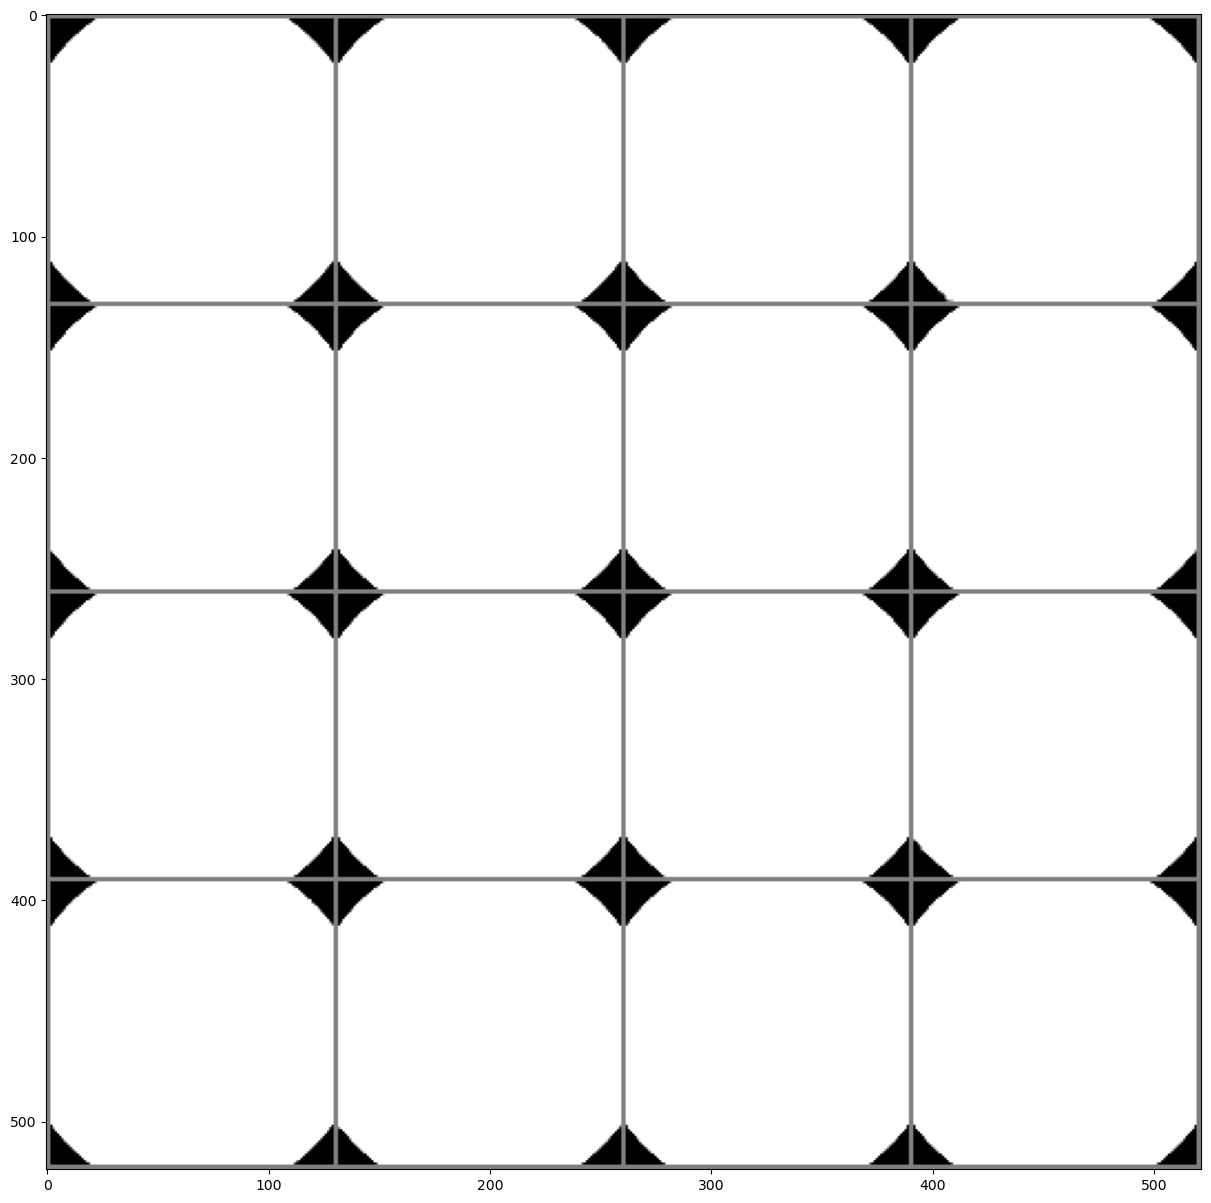

torch.Size([16, 3, 4, 128, 128])


RuntimeError: The size of tensor a (4) must match the size of tensor b (128) at non-singleton dimension 2

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
%matplotlib inline 
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_pred(img):
    npimg = img.numpy() * 255
    print(npimg.shape)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(valloader)
batch = next(dataiter)
images, labels = batch['img'], batch['label']
# show images
imshow(torchvision.utils.make_grid(images,nrow=4))
labels_image = torch.cat([labels.unsqueeze(1),labels.unsqueeze(1),labels.unsqueeze(1)],dim=1)
print(labels_image.shape)
imshow_pred(torchvision.utils.make_grid(labels_image,nrow=4))
# print labels
output = model(images.to(device))
_, preds = torch.max(output, 1)
preds = torch.cat([preds.unsqueeze(1),preds.unsqueeze(1),preds.unsqueeze(1)],dim=1)
print(preds.shape)
imshow_pred(torchvision.utils.make_grid(preds.cpu(),nrow=4))